In [2]:
from six.moves import urllib
from scipy.io import loadmat
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
print("Success!")

Success!


In [3]:
mnist

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original'}

In [4]:
X,y=mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

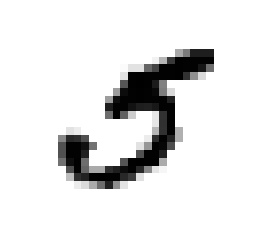

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = matplotlib.cm.binary,
          interpolation = "nearest") # 이 함수를 사용해 그림을 그림
plt.axis("off")
plt.show()

In [7]:
y[36000] #실제 레이블 확인

5.0

In [8]:
#데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야한다.
X_train, X_test , y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [9]:
#훈련세트를 섞어서 모든 교차 검증 폴드가 비슷해지도록 / 비슷한 샘플이 연이어 나타나면 성능이 나빠짐
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train=X_train[shuffle_index],y_train[shuffle_index]

In [10]:
#이진 분류기 훈련 ( 5와 5아님 두 개의 클래스를 구분할 수 있음)
y_train_5 = (y_train == 5) #5는 ture이고 , 다른 숫자는 모두 false
y_test_5 = (y_test == 5)

In [11]:
# 확률적 경사 하강법
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([False])

In [13]:
#성능 측정
#교차 검증을 사용한 정확도 측정
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95145, 0.9615 , 0.96865])

In [14]:
#정확도가 95% 이상이다.
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")
#정확도가 90%이상으로 나옴

array([0.91055, 0.9086 , 0.9098 ])

In [16]:
#오차행렬
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53249,  1330],
       [ 1038,  4383]])

In [18]:
#정밀도와 재현율
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5, y_train_pred)

0.7671976194643795

In [19]:
recall_score(y_train_5, y_train_pred)

0.8085224128389596

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7873181246631938

In [21]:
#정밀도/ 재현율 트레이드오프
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-78839.10099692])

In [22]:
threshold = 0
y_some_digit_pred = ( y_scores > threshold)

In [23]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

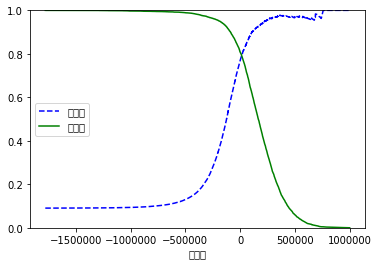

In [26]:
#맷플롯립을 이용해 임곗값의 함수로 정밀도와 재현율을 그릴 수 있다,
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1],"b--",label="정밀도")
    plt.plot(thresholds, recalls[:-1],"g-",label="재현율")
    plt.xlabel("임곗값")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [27]:
y_train_pred_90 = (y_scores > 70000)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.8612319670254179

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.693783434790629

In [30]:
#ROC곡선
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

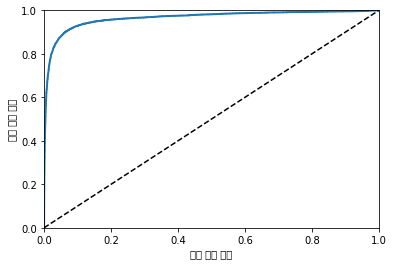

In [31]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('거짓 양성 비율')
    plt.ylabel('진짜 양성 비율')

plot_roc_curve(fpr,tpr)
plt.show()

In [32]:
#곡선 아래의 면적
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9649890005588518

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

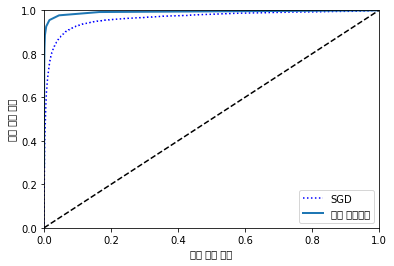

In [34]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest, tpr_forest,"랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

In [35]:
roc_auc_score(y_train_5,y_scores_forest)

0.992507625549941

In [36]:
#다중 분류
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5.])

In [37]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-132190.72411216, -485766.39208653, -431519.37309146,
        -160981.37405341, -384793.54605677,  -78839.10099692,
        -785004.320269  , -310196.77070644, -646444.00446173,
        -752081.85418065]])

In [38]:
#가장 높은 점수가 클래스 5에 해당하는 값이다
np.argmax(some_digit_scores)

5

In [39]:
sgd_clf.classes_
sgd_clf.classes_[5]

5.0

In [40]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [41]:
len(ovo_clf.estimators_)

45

In [42]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [43]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.1, 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86067786, 0.86684334, 0.86017903])

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv =3, scoring="accuracy")

array([0.91236753, 0.91184559, 0.90678602])

In [46]:
#에러분석
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   23,    9,   10,   52,   47,    9,   39,    6],
       [   1, 6463,   42,   30,    5,   42,    9,   11,  129,   10],
       [  50,   37, 5341,   94,   84,   23,   96,   60,  159,   14],
       [  49,   41,  137, 5345,    3,  248,   31,   53,  132,   92],
       [  20,   29,   36,    8, 5381,   11,   48,   25,   81,  203],
       [  60,   43,   41,  171,   76, 4619,  102,   32,  183,   94],
       [  34,   23,   42,    2,   44,   97, 5616,    6,   53,    1],
       [  23,   23,   67,   26,   52,    9,    7, 5828,   14,  216],
       [  50,  145,   77,  144,   15,  162,   55,   23, 5038,  142],
       [  39,   36,   32,   88,  167,   37,    3,  205,   78, 5264]])

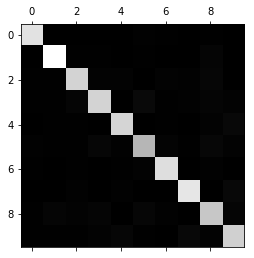

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

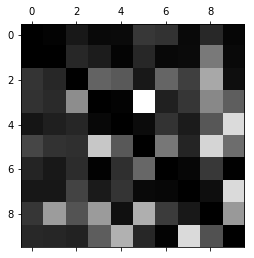

In [48]:
#그래프의 에러부분에 초점을 맞춤
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx/ row_sums

#다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그림
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [49]:
#다중 레이블 분류
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [50]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [51]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3,
                                    n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro"

SyntaxError: unexpected EOF while parsing (<ipython-input-51-1f29d95c4116>, line 3)

In [ ]:
#다중 출력 분류
noise = rnd.randint(0,100(len(X_train),784))
X_train_mod = X_train +noise
noise = rnd.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)